In [1]:
import optuna
import optuna.visualization as ov
from optuna.samplers import TPESampler
import plotly
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, auc
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import pickle
import os
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, f1_score
)


/Users/carlachira/anaconda3/envs/ml_env/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('cleanedData.csv')
data = data.drop("Order", axis = 'columns')
data = data.drop("PID", axis = 'columns')
print(data.shape)
data.head()

(2930, 74)


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,3Ssn Porch,Screen Porch,Fence,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,HasFence
0,20,RL,141.0,31770,1,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,NoFence,0,5,2010,WD,Normal,215000,0
1,20,RH,80.0,11622,1,Reg,Lvl,AllPub,Inside,Gtl,...,0,120,MnPrv,0,6,2010,WD,Normal,105000,1
2,20,RL,81.0,14267,1,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,NoFence,12500,6,2010,WD,Normal,172000,0
3,20,RL,93.0,11160,1,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,NoFence,0,4,2010,WD,Normal,244000,0
4,60,RL,74.0,13830,1,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,MnPrv,0,3,2010,WD,Normal,189900,1


In [3]:
X, y = data.drop("SalePrice", axis = 'columns'), data['SalePrice']
X.head()


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Enclosed Porch,3Ssn Porch,Screen Porch,Fence,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,HasFence
0,20,RL,141.0,31770,1,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,NoFence,0,5,2010,WD,Normal,0
1,20,RH,80.0,11622,1,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,120,MnPrv,0,6,2010,WD,Normal,1
2,20,RL,81.0,14267,1,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,NoFence,12500,6,2010,WD,Normal,0
3,20,RL,93.0,11160,1,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,NoFence,0,4,2010,WD,Normal,0
4,60,RL,74.0,13830,1,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,MnPrv,0,3,2010,WD,Normal,1


In [4]:
y_classesI = pd.cut(
    y,
    bins=10, 
    labels=False, 
    include_lowest=True 
)
print(y_classesI.head())

0    2
1    1
2    2
3    3
4    2
Name: SalePrice, dtype: int64


In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encodedI = le.fit_transform(y_classesI.dropna())


In [6]:
X_numeric = pd.get_dummies(X) 
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y_encodedI, test_size=0.1, random_state=42
)

In [7]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    model = XGBClassifier(
        **params,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=len(np.unique(y_classesI))
    )

    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)

    f1 = f1_score(y_test, y_pred, average='macro')
    return f1


In [8]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=10)


[I 2025-11-19 12:42:39,209] A new study created in memory with name: no-name-bedd1808-7cf7-4e1a-add8-6f7a68fbaf0e
[I 2025-11-19 12:42:40,090] Trial 0 finished with value: 0.5231148625887269 and parameters: {'max_depth': 6, 'learning_rate': 0.15834953127469747, 'n_estimators': 105, 'subsample': 0.5592127972045073, 'colsample_bytree': 0.9799870696267434, 'gamma': 1.8364142064795002, 'reg_alpha': 0.5421349015072899, 'reg_lambda': 0.24132843644115642}. Best is trial 0 with value: 0.5231148625887269.
[I 2025-11-19 12:42:41,553] Trial 1 finished with value: 0.49802710533117994 and parameters: {'max_depth': 6, 'learning_rate': 0.20722332317574524, 'n_estimators': 266, 'subsample': 0.6583578525274093, 'colsample_bytree': 0.5298120707650003, 'gamma': 4.708032323554855, 'reg_alpha': 0.8406508085271318, 'reg_lambda': 0.5081663297743618}. Best is trial 0 with value: 0.5231148625887269.
[I 2025-11-19 12:42:43,293] Trial 2 finished with value: 0.5131093799717592 and parameters: {'max_depth': 6, 'lea

In [9]:
best_trial = study.best_trial
print("Best Macro F1:", best_trial.value)
print("Best hyperparameters:", best_trial.params)


Best Macro F1: 0.5425115528563804
Best hyperparameters: {'max_depth': 7, 'learning_rate': 0.1410165639962179, 'n_estimators': 975, 'subsample': 0.5733625570397677, 'colsample_bytree': 0.6136729896751515, 'gamma': 3.9756545848050875, 'reg_alpha': 0.5149946469001494, 'reg_lambda': 0.5865209289173279}


In [10]:
import nbformat
ov.plot_optimization_history(study).show()
ov.plot_param_importances(study).show()

In [11]:
best_params = best_trial.params
final_model = XGBClassifier(
    **best_params,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(y_classesI))
)

final_model.fit(X_train, y_train)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6136729896751515
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [12]:
from sklearn.metrics import accuracy_score, classification_report
import sklearn
y_predI = final_model.predict(X_test)
y_probI = final_model.predict_proba(X_test)

print("\n Accuracy:", accuracy_score(y_test, y_predI))

print("\n f1 score: ", sklearn.metrics.f1_score(y_test, y_predI, average='weighted'))

print("\n Precision:", sklearn.metrics.precision_score(y_test, y_predI, average='weighted', zero_division=0))

print("\n Recall", sklearn.metrics.recall_score(y_test, y_predI, average='weighted', zero_division=0))

print("\n Predicted class labels:", y_predI[:5])
print(" Actual class labels   :", y_test[:5])


 Accuracy: 0.8156996587030717

 f1 score:  0.8097663956908396

 Precision: 0.8048391226457539

 Recall 0.8156996587030717

 Predicted class labels: [1 1 2 1 1]
 Actual class labels   : [1 1 2 1 1]


In [13]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=50)


[I 2025-11-19 12:43:45,036] A new study created in memory with name: no-name-966011b8-93e4-49d1-96fb-98ab9c5f5439
[I 2025-11-19 12:43:50,977] Trial 0 finished with value: 0.46282371172445685 and parameters: {'max_depth': 7, 'learning_rate': 0.049525694205708765, 'n_estimators': 974, 'subsample': 0.7799547524369659, 'colsample_bytree': 0.8448700220164214, 'gamma': 1.174171975315077, 'reg_alpha': 0.37056172770867424, 'reg_lambda': 0.4376439957589061}. Best is trial 0 with value: 0.46282371172445685.
[I 2025-11-19 12:43:54,234] Trial 1 finished with value: 0.5199642767608347 and parameters: {'max_depth': 11, 'learning_rate': 0.038137174212856194, 'n_estimators': 539, 'subsample': 0.6059539819206992, 'colsample_bytree': 0.6678187508877967, 'gamma': 3.958373115475789, 'reg_alpha': 0.7042356874274736, 'reg_lambda': 0.7515977018188404}. Best is trial 1 with value: 0.5199642767608347.
[I 2025-11-19 12:43:57,480] Trial 2 finished with value: 0.5171874445270013 and parameters: {'max_depth': 5, '

In [14]:
best_trial = study.best_trial
print("Best Macro F1:", best_trial.value)
print("Best hyperparameters:", best_trial.params)


Best Macro F1: 0.5482383543444417
Best hyperparameters: {'max_depth': 10, 'learning_rate': 0.11143438032649791, 'n_estimators': 923, 'subsample': 0.7671416849768249, 'colsample_bytree': 0.832648834690536, 'gamma': 0.3838977417880442, 'reg_alpha': 0.0947472255248661, 'reg_lambda': 0.5772228529434014}


In [16]:
ov.plot_optimization_history(study).show()
ov.plot_param_importances(study).show()

In [17]:
best_params = best_trial.params
final_model = XGBClassifier(
    **best_params,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(y_classesI))
)

final_model.fit(X_train, y_train)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.832648834690536
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [18]:
from sklearn.metrics import accuracy_score, classification_report
import sklearn
y_predI = final_model.predict(X_test)
y_probI = final_model.predict_proba(X_test)

print("\n Accuracy:", accuracy_score(y_test, y_predI))

print("\n f1 score: ", sklearn.metrics.f1_score(y_test, y_predI, average='weighted'))

print("\n Precision:", sklearn.metrics.precision_score(y_test, y_predI, average='weighted', zero_division=0))

print("\n Recall", sklearn.metrics.recall_score(y_test, y_predI, average='weighted', zero_division=0))

print("\n Predicted class labels:", y_predI[:5])
print(" Actual class labels   :", y_test[:5])


 Accuracy: 0.8191126279863481

 f1 score:  0.8151394496182789

 Precision: 0.8122830564035768

 Recall 0.8191126279863481

 Predicted class labels: [1 1 2 1 1]
 Actual class labels   : [1 1 2 1 1]


In [19]:
study30 = optuna.create_study(direction='maximize', sampler=TPESampler())
study30.optimize(objective, n_trials=30)

[I 2025-11-19 12:47:59,601] A new study created in memory with name: no-name-bcb4befc-af77-434b-b94d-3930550ce62b
[I 2025-11-19 12:48:04,399] Trial 0 finished with value: 0.5091085670078507 and parameters: {'max_depth': 10, 'learning_rate': 0.020852211448004206, 'n_estimators': 706, 'subsample': 0.9745418914354169, 'colsample_bytree': 0.7366863460309194, 'gamma': 4.465775596121802, 'reg_alpha': 0.24075294875912479, 'reg_lambda': 0.5913113787084071}. Best is trial 0 with value: 0.5091085670078507.
[I 2025-11-19 12:48:07,632] Trial 1 finished with value: 0.45996979859204173 and parameters: {'max_depth': 5, 'learning_rate': 0.29205030261955234, 'n_estimators': 537, 'subsample': 0.7295637176189766, 'colsample_bytree': 0.534079821596846, 'gamma': 0.12290316963506409, 'reg_alpha': 0.7024782701177231, 'reg_lambda': 0.7960502710818115}. Best is trial 0 with value: 0.5091085670078507.
[I 2025-11-19 12:48:11,666] Trial 2 finished with value: 0.5297104941841784 and parameters: {'max_depth': 8, 'l

In [20]:
best_trial30 = study30.best_trial
print("Best Macro F1:", best_trial30.value)
print("Best hyperparameters:", best_trial30.params)

Best Macro F1: 0.5366946426174175
Best hyperparameters: {'max_depth': 8, 'learning_rate': 0.09820050934136373, 'n_estimators': 815, 'subsample': 0.696309002321594, 'colsample_bytree': 0.9496679294988845, 'gamma': 3.903819857274566, 'reg_alpha': 0.40376314539625174, 'reg_lambda': 0.9914815040327843}


In [21]:
best_params30 = best_trial30.params
final_model30 = XGBClassifier(
    **best_params,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(y_classesI))
)

final_model30.fit(X_train, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.832648834690536
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [22]:
from sklearn.metrics import accuracy_score, classification_report
import sklearn
y_predI30 = final_model30.predict(X_test)
y_probI30 = final_model30.predict_proba(X_test)

print("\n Accuracy:", accuracy_score(y_test, y_predI30))

print("\n f1 score: ", sklearn.metrics.f1_score(y_test, y_predI30, average='weighted'))

print("\n Precision:", sklearn.metrics.precision_score(y_test, y_predI30, average='weighted', zero_division=0))

print("\n Recall", sklearn.metrics.recall_score(y_test, y_predI30, average='weighted', zero_division=0))

print("\n Predicted class labels:", y_predI30[:5])
print(" Actual class labels   :", y_test[:5])


 Accuracy: 0.8191126279863481

 f1 score:  0.8151394496182789

 Precision: 0.8122830564035768

 Recall 0.8191126279863481

 Predicted class labels: [1 1 2 1 1]
 Actual class labels   : [1 1 2 1 1]


ROC Curve for Multi-Class XGBoost

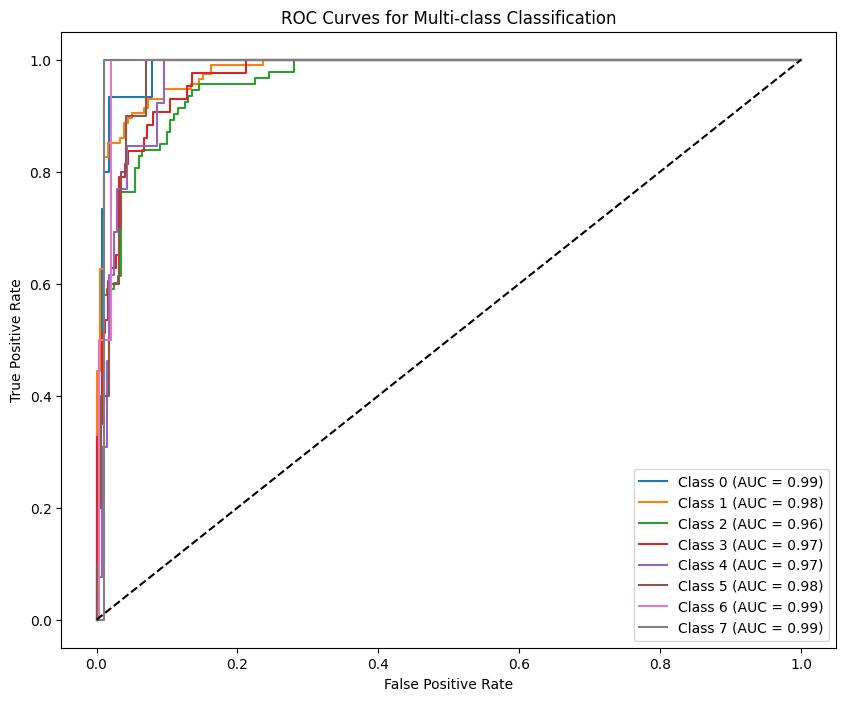

In [23]:
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probI[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class Classification')
plt.legend(loc='lower right')
plt.show()

In [24]:
best_treshold = {}
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], y_probI[:, i])
    j_scores = tpr - fpr
    best_threshold_index = np.argmax(j_scores)

    best_treshold[i] = {
        'threshold': thresholds[best_threshold_index],
        'tpr': tpr[best_threshold_index],
        'fpr': fpr[best_threshold_index]
    }

print("Best thresholds for each class:")
for cls, vals in best_treshold.items():
    print(f"Class {cls}: Threshold = {vals['threshold']:.4f}, TPR = {vals['tpr']:.4f}, FPR = {vals['fpr']:.4f}")

Best thresholds for each class:
Class 0: Threshold = 0.0169, TPR = 1.0000, FPR = 0.0791
Class 1: Threshold = 0.3728, TPR = 0.9304, FPR = 0.0730
Class 2: Threshold = 0.1434, TPR = 0.9570, FPR = 0.1450
Class 3: Threshold = 0.0594, TPR = 0.9767, FPR = 0.1360
Class 4: Threshold = 0.0547, TPR = 1.0000, FPR = 0.0964
Class 5: Threshold = 0.0072, TPR = 1.0000, FPR = 0.0707
Class 6: Threshold = 0.0471, TPR = 1.0000, FPR = 0.0206
Class 7: Threshold = 0.0141, TPR = 1.0000, FPR = 0.0103


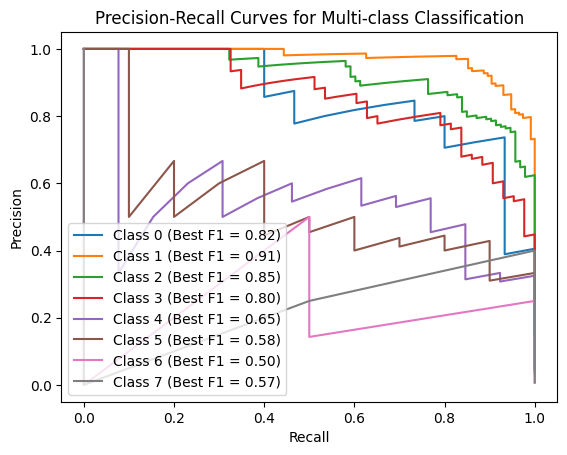

Best PR thresholds per class: {0: np.float32(0.18905759), 1: np.float32(0.6081031), 2: np.float32(0.51493245), 3: np.float32(0.33594558), 4: np.float32(0.31814107), 5: np.float32(0.020309722), 6: np.float32(0.10080881), 7: np.float32(0.01411489)}


In [25]:
from sklearn.metrics import precision_recall_curve

best_pr_thresholds = {}
n_classes = y_test_bin.shape[1]

plt.figure()
for i in range(n_classes):
    precision, recall, thresholds = precision_recall_curve(y_test_bin[:, i], y_probI[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_pr_thresholds[i] = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    plt.plot(recall, precision, label=f'Class {i} (Best F1 = {f1_scores[best_idx]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Multi-class Classification')
plt.legend()
plt.show()
print("Best PR thresholds per class:", best_pr_thresholds)


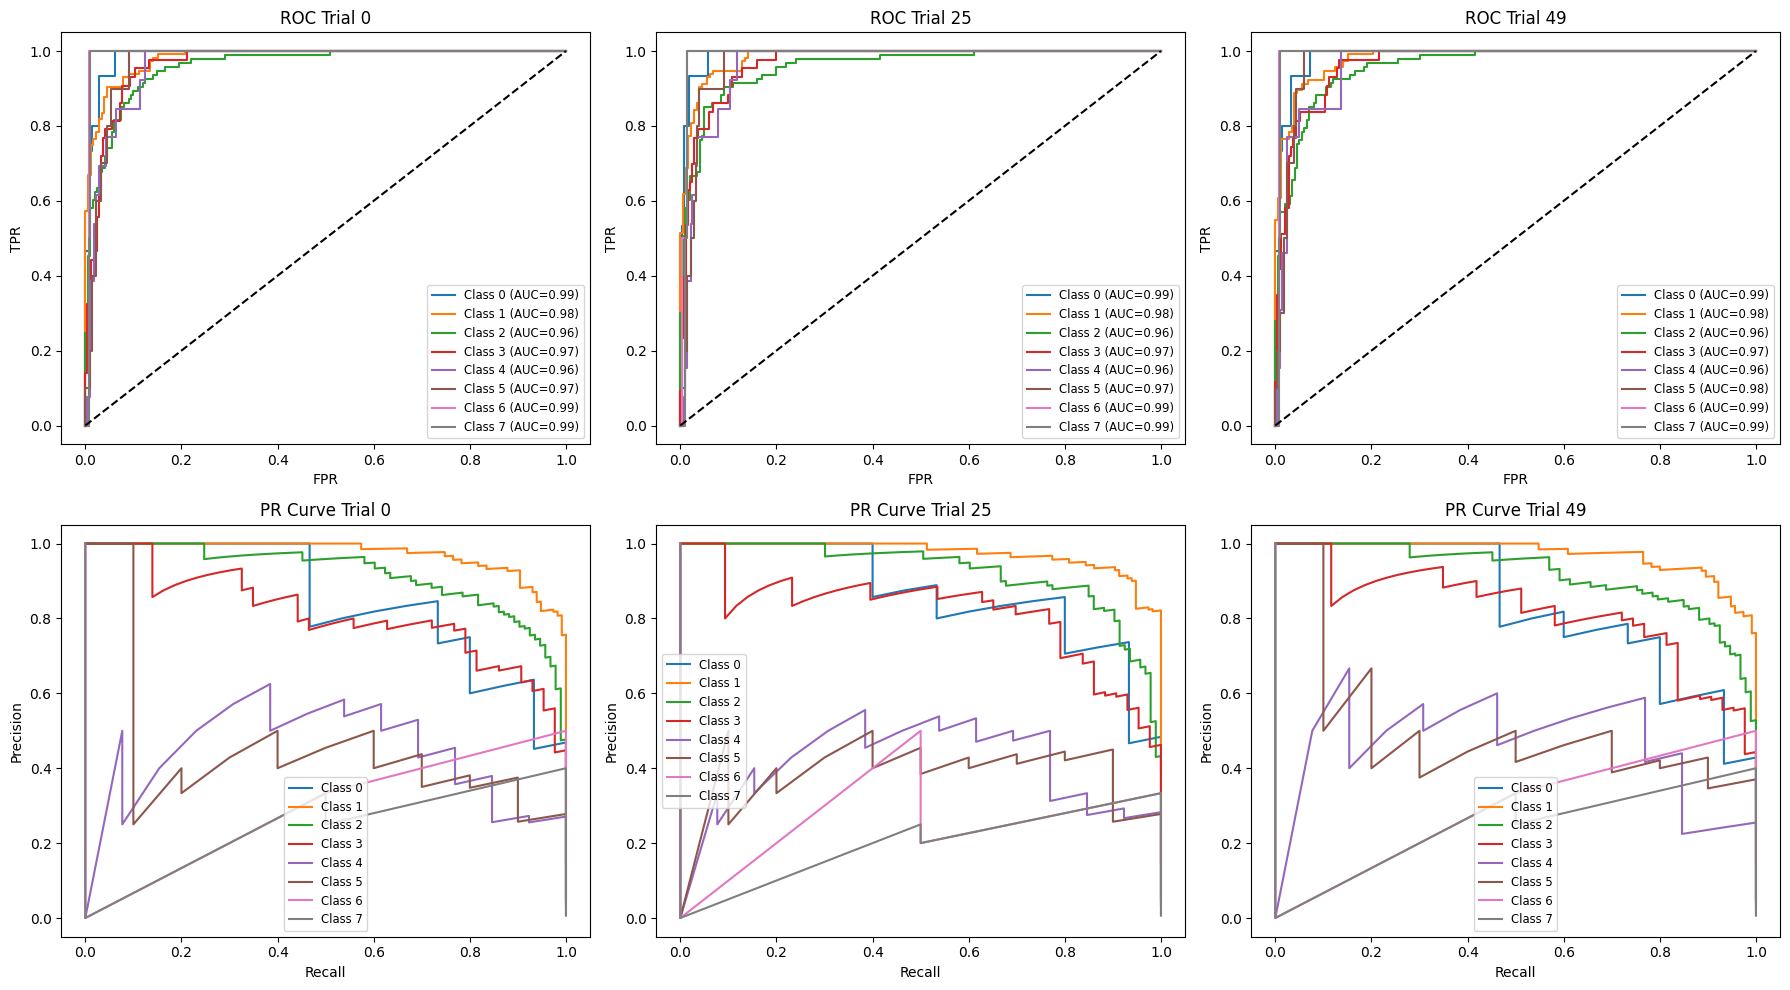

In [26]:
n_classes = y_test_bin.shape[1]
iteration_indices = [0, len(study.trials)//2, len(study.trials)-1]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for col_idx, trial_idx in enumerate(iteration_indices):
    trial_params = study.trials[trial_idx].params
    iter_model = XGBClassifier(
        **trial_params,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=n_classes
    )
    iter_model.fit(X_train, y_train)
    y_prob_iter = iter_model.predict_proba(X_test)
    
    # ROC Curve
    ax_roc = axes[0, col_idx]
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_iter[:, i])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')
    ax_roc.plot([0, 1], [0, 1], 'k--')
    ax_roc.set_title(f'ROC Trial {trial_idx}')
    ax_roc.set_xlabel('FPR')
    ax_roc.set_ylabel('TPR')
    ax_roc.legend(fontsize='small')

    # Precision-Recall Curve
    ax_pr = axes[1, col_idx]
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob_iter[:, i])
        ax_pr.plot(recall, precision, label=f'Class {i}')
    ax_pr.set_title(f'PR Curve Trial {trial_idx}')
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.legend(fontsize='small')

plt.tight_layout()
plt.show()


In [35]:
study_name = "dez"
model_dir = f"./artifacts/{study_name}/models"
os.makedirs(model_dir, exist_ok=True)
artifact_store = optuna.artifacts.FileSystemArtifactStore( "./artifacts")


In [36]:
price = data["SalePrice"].copy() #dezechilibru
    
low_thr = price.quantile(0.05)
high_thr = price.quantile(0.95)
    
middle = price[(price >= low_thr) & (price <= high_thr)]
bins = np.linspace(low_thr, high_thr, 9)
    
classes = pd.cut(
    price,
    bins=[-np.inf] + list(bins) + [np.inf],
    labels=list(range(1, 11)),
    include_lowest=True
    )
y_classD = classes.astype(int) - 1
y_classD

0       5
1       1
2       3
3       6
4       4
       ..
2925    2
2926    2
2927    2
2928    3
2929    4
Name: SalePrice, Length: 2930, dtype: int64

In [37]:
class_counts = y_classD.value_counts(normalize=True)
class_weights = 1 / (class_counts ** 0.5)
weights = y_classD.map(class_weights)

In [38]:
Xd = data.drop(columns=["SalePrice"])
Xd = pd.get_dummies(Xd)
X_trainD, X_testD, y_trainD, y_testD = train_test_split(
    Xd, y_classD, 
    stratify=y_classD, 
    test_size=0.1,
    random_state=42
)

In [39]:
weights_train = y_trainD.map(class_weights)
# weights_test = y_testD.map(class_weights)

In [ ]:
def objectiveD(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }


    model = XGBClassifier(
        **params,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=len(np.unique(y_classD))
    )

    model.fit(
        X_trainD,
        y_trainD,
        sample_weight=weights_train,
        eval_set=[(X_testD, y_testD)],
        verbose=False
    )

    tmp_path = os.path.join(model_dir, f"model_trial_{trial.number}.pkl")
    with open(tmp_path, "wb") as f:
        pickle.dump(model, f)

    artifact_id = optuna.artifacts.upload_artifact(
        artifact_store=artifact_store,
        file_path=tmp_path,
        study_or_trial=trial
    )
    trial.set_user_attr("artifact_id", artifact_id)

    y_pred_probaD = model.predict_proba(X_testD)
    y_predD = np.argmax(y_pred_probaD, axis=1)

    f1 = f1_score(y_testD, y_predD, average='macro')
    return f1


In [41]:
studyD = optuna.create_study(direction='maximize', sampler=TPESampler())
studyD.optimize(objectiveD, n_trials=100)

[I 2025-11-19 13:56:35,888] A new study created in memory with name: no-name-3873d1c5-e9a0-47c1-8513-8c81487f1f19
[I 2025-11-19 13:56:41,901] Trial 0 finished with value: 0.5137455511846464 and parameters: {'max_depth': 11, 'learning_rate': 0.09880305329568673, 'n_estimators': 829, 'subsample': 0.9514614768160686, 'colsample_bytree': 0.7760519463975362, 'gamma': 4.869569922484718, 'reg_alpha': 0.22041368493111935, 'reg_lambda': 0.25347612666559627}. Best is trial 0 with value: 0.5137455511846464.
[I 2025-11-19 13:56:45,526] Trial 1 finished with value: 0.5440587892510971 and parameters: {'max_depth': 12, 'learning_rate': 0.01478310494971083, 'n_estimators': 113, 'subsample': 0.5846619005609335, 'colsample_bytree': 0.7129118564339844, 'gamma': 3.666736540359004, 'reg_alpha': 0.7730621815652828, 'reg_lambda': 0.11388152042933652}. Best is trial 1 with value: 0.5440587892510971.
[I 2025-11-19 13:56:49,175] Trial 2 finished with value: 0.4723205222950152 and parameters: {'max_depth': 12, '

In [43]:
studyD.optimize(objectiveD, n_trials=50)

[I 2025-11-19 14:13:49,809] Trial 100 finished with value: 0.5686433928919054 and parameters: {'max_depth': 4, 'learning_rate': 0.060694284267380494, 'n_estimators': 746, 'subsample': 0.6998556422981173, 'colsample_bytree': 0.513060630672722, 'gamma': 1.6043268868140266, 'reg_alpha': 0.9263202835490036, 'reg_lambda': 0.10592333726076195}. Best is trial 64 with value: 0.5796884946837337.
[I 2025-11-19 14:13:55,043] Trial 101 finished with value: 0.5487082333004627 and parameters: {'max_depth': 4, 'learning_rate': 0.25725196190903565, 'n_estimators': 819, 'subsample': 0.6997213404398394, 'colsample_bytree': 0.6891824110594632, 'gamma': 1.623467271966066, 'reg_alpha': 0.9339376349449519, 'reg_lambda': 0.11626681148879475}. Best is trial 64 with value: 0.5796884946837337.
[I 2025-11-19 14:14:02,335] Trial 102 finished with value: 0.5595949822622852 and parameters: {'max_depth': 4, 'learning_rate': 0.06091931867962407, 'n_estimators': 703, 'subsample': 0.6784152586954241, 'colsample_bytree'

In [44]:
best_trialD = studyD.best_trial
print("Best Macro F1:", best_trialD.value)
print("Best hyperparameters:", best_trialD.params)

Best Macro F1: 0.5863184625758624
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.061020607285545196, 'n_estimators': 824, 'subsample': 0.6988689465623713, 'colsample_bytree': 0.5078364982534695, 'gamma': 3.282492693947333, 'reg_alpha': 0.32877654099011044, 'reg_lambda': 0.10978578502258829}


In [45]:
best_paramsD = best_trialD.params
final_modelD = XGBClassifier(
    **best_paramsD,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(y_classD))
)

final_modelD.fit(X_trainD, y_trainD)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5078364982534695
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [46]:
from sklearn.metrics import accuracy_score, classification_report
import sklearn
y_predD = final_modelD.predict(X_testD)
y_probD = final_modelD.predict_proba(X_testD)

print("\n Accuracy:", accuracy_score(y_testD, y_predD))

print("\n f1 score: ", sklearn.metrics.f1_score(y_testD, y_predD, average='weighted'))

print("\n Precision:", sklearn.metrics.precision_score(y_testD, y_predD, average='weighted', zero_division=0))

print("\n Recall", sklearn.metrics.recall_score(y_testD, y_predD, average='weighted', zero_division=0))

print("\n Predicted class labels:", y_predD[:5])
print(" Actual class labels   :", y_testD[:5])


 Accuracy: 0.6245733788395904

 f1 score:  0.6152007840804884

 Precision: 0.6178544746513899

 Recall 0.6245733788395904

 Predicted class labels: [6 2 4 2 2]
 Actual class labels   : 1786    5
2855    2
462     3
2580    2
1870    2
Name: SalePrice, dtype: int64


In [47]:
def load_model_by_trial_number(n):
    trial = studyD.trials[n]
    artifact_id = trial.user_attrs["artifact_id"]
    local_path = f"./artifacts/dez/models/model_loaded_{n}.pkl"
    
    optuna.artifacts.download_artifact(
        artifact_store=artifact_store,
        artifact_id=artifact_id,
        file_path=local_path
    )
    with open(local_path, "rb") as f:
        return pickle.load(f)

first = load_model_by_trial_number(0)
middle = load_model_by_trial_number(len(study.trials)//2)
last = load_model_by_trial_number(len(study.trials)-1)

models = {
    "First Trial": first,
    "Middle Trial": middle,
    "Last Trial": last
}

In [48]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize


def plot_curves(model, X_valid, y_valid, label):

    probs = model.predict_proba(X_valid)
    classes = np.unique(y_valid)


    y_valid_bin = label_binarize(y_valid, classes=classes)

    # ROC
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"ROC Curve – {label}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    roc_info = {}

    for i, cls in enumerate(classes):
        fpr, tpr, thr = roc_curve(y_valid_bin[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {roc_auc:.3f})")
        roc_info[cls] = {"fpr": fpr, "tpr": tpr, "thresholds": thr, "auc": roc_auc}

    plt.legend()

    # Precision–Recall curves & best F1 thresholds
    plt.subplot(1, 2, 2)
    plt.title(f"Precision–Recall – {label}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")

    best_thresholds = {}

    for i, cls in enumerate(classes):
        precision, recall, thr = precision_recall_curve(
            y_valid_bin[:, i], probs[:, i]
        )
        f1 = (2 * precision * recall) / (precision + recall + 1e-12)
        idx = np.argmax(f1)

        best_thr = thr[idx if idx < len(thr) else -1]
        best_thresholds[cls] = best_thr

        plt.plot(recall, precision, label=f"Class {cls}")
        plt.scatter(recall[idx], precision[idx], color="black")

    plt.legend()
    plt.tight_layout()
    plt.show()

    return best_thresholds


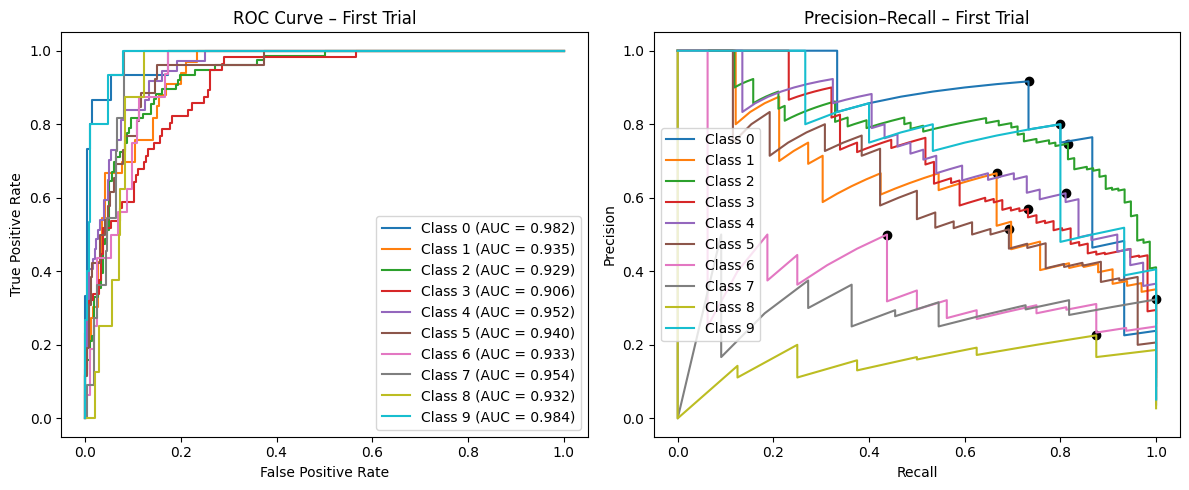

First Trial: Best thresholds per class = {np.int64(0): np.float32(0.34641382), np.int64(1): np.float32(0.46546456), np.int64(2): np.float32(0.40312365), np.int64(3): np.float32(0.28701285), np.int64(4): np.float32(0.33152327), np.int64(5): np.float32(0.24408965), np.int64(6): np.float32(0.2764476), np.int64(7): np.float32(0.11792469), np.int64(8): np.float32(0.07886635), np.int64(9): np.float32(0.37626997)}


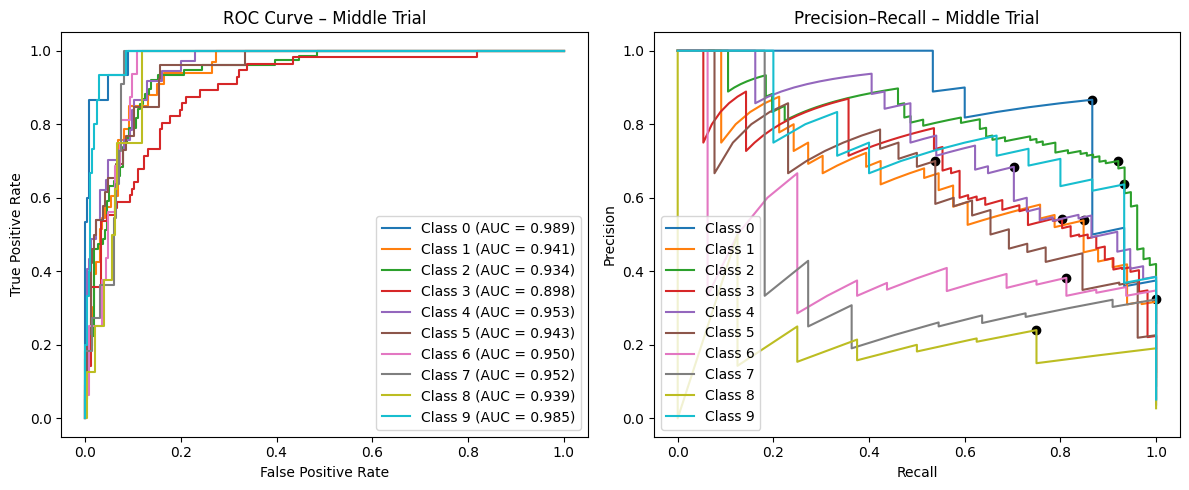

Middle Trial: Best thresholds per class = {np.int64(0): np.float32(0.22872266), np.int64(1): np.float32(0.18068665), np.int64(2): np.float32(0.31807932), np.int64(3): np.float32(0.2679448), np.int64(4): np.float32(0.4124783), np.int64(5): np.float32(0.36500108), np.int64(6): np.float32(0.17037767), np.int64(7): np.float32(0.11787395), np.int64(8): np.float32(0.08946135), np.int64(9): np.float32(0.25648922)}


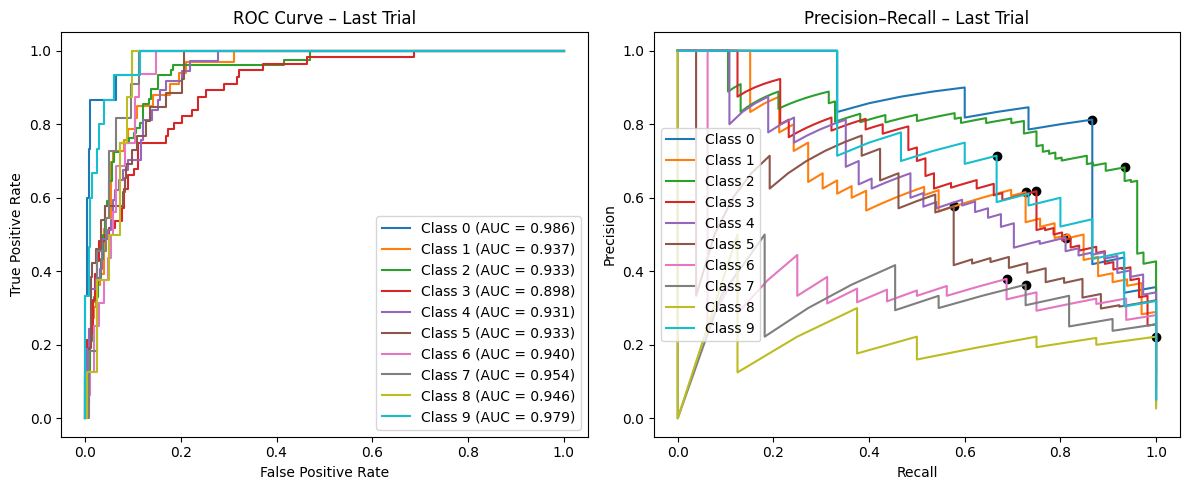

Last Trial: Best thresholds per class = {np.int64(0): np.float32(0.2810098), np.int64(1): np.float32(0.4134562), np.int64(2): np.float32(0.26212084), np.int64(3): np.float32(0.3420304), np.int64(4): np.float32(0.2501015), np.int64(5): np.float32(0.26031363), np.int64(6): np.float32(0.20081826), np.int64(7): np.float32(0.19678032), np.int64(8): np.float32(0.05612707), np.int64(9): np.float32(0.39458916)}


In [49]:

for name, model in models.items():
    best_thresholds = plot_curves(model, X_testD, y_testD, name)
    print(f"{name}: Best thresholds per class = {best_thresholds}")

In [50]:
def objectivePR(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    model = XGBClassifier(
        **params,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=len(np.unique(y_classD))
    )

    model.fit(X_trainD, y_trainD)
    y_pred_proba = model.predict_proba(X_testD)
    y_pred = np.argmax(y_pred_proba, axis=1)

    f1 = f1_score(y_testD, y_pred, average='macro')
    return f1

In [51]:
studyPR = optuna.create_study(direction='maximize', sampler=TPESampler())
studyPR.optimize(objectivePR, n_trials=50)

[I 2025-11-19 14:19:56,795] A new study created in memory with name: no-name-042c2386-7f2b-453f-ab90-913080472a2a
[I 2025-11-19 14:20:01,325] Trial 0 finished with value: 0.5053474679336876 and parameters: {'max_depth': 5, 'learning_rate': 0.07571931637290384, 'n_estimators': 803, 'subsample': 0.9203499674230341, 'colsample_bytree': 0.5414613321956063, 'gamma': 4.353146122147043, 'reg_alpha': 0.7426848206938441, 'reg_lambda': 0.9811857174591005}. Best is trial 0 with value: 0.5053474679336876.
[I 2025-11-19 14:20:05,713] Trial 1 finished with value: 0.5086457635131643 and parameters: {'max_depth': 6, 'learning_rate': 0.2494477415651772, 'n_estimators': 772, 'subsample': 0.5143783566747648, 'colsample_bytree': 0.6646287896157035, 'gamma': 2.1404544844703826, 'reg_alpha': 0.43299185789422723, 'reg_lambda': 0.5242834415600903}. Best is trial 1 with value: 0.5086457635131643.
[I 2025-11-19 14:20:08,228] Trial 2 finished with value: 0.4576648463230673 and parameters: {'max_depth': 6, 'learn

In [52]:
best_trialPR = studyPR.best_trial
print("Best Macro F1:", best_trialPR.value)
print("Best hyperparameters:", best_trialPR.params)

Best Macro F1: 0.5606889750223016
Best hyperparameters: {'max_depth': 8, 'learning_rate': 0.04439457608387824, 'n_estimators': 593, 'subsample': 0.5100452108005592, 'colsample_bytree': 0.8247423811468656, 'gamma': 2.1065400528108347, 'reg_alpha': 0.1681292935929893, 'reg_lambda': 0.40378734606352046}


In [53]:
best_paramsPR = best_trialPR.params
final_modelPR = XGBClassifier(
    **best_params,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(y_classD))
)

final_modelPR.fit(X_trainD, y_trainD)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.832648834690536
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [55]:
from sklearn.metrics import accuracy_score, classification_report
import sklearn
y_predPR = final_modelPR.predict(X_testD)
y_probPR = final_modelPR.predict_proba(X_testD)

y_predPR = np.where(y_probPR[:, 0] > 0.15, 0, y_probPR.argmax(axis=1))
y_predPR = np.where(y_probPR[:, 9] > 0.15, 9, y_probPR.argmax(axis=1))

print("\n Accuracy:", accuracy_score(y_testD, y_predPR))

print("\n f1 score macro: ", sklearn.metrics.f1_score(y_testD, y_predPR, average='macro'))

print("\n Precision:", sklearn.metrics.precision_score(y_testD, y_predPR, average='weighted', zero_division=0))

print("\n Recall", sklearn.metrics.recall_score(y_testD, y_predPR, average='weighted', zero_division=0))

print("\n Predicted class labels:", y_predPR[:5])
print(" Actual class labels   :", y_testD[:5])


 Accuracy: 0.6416382252559727

 f1 score macro:  0.5400763441442418

 Precision: 0.6331225024606313

 Recall 0.6416382252559727

 Predicted class labels: [6 3 4 2 2]
 Actual class labels   : 1786    5
2855    2
462     3
2580    2
1870    2
Name: SalePrice, dtype: int64


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import sklearn
y_predN = final_modelPR.predict(X_testD) #nothing
y_probN = final_modelPR.predict_proba(X_testD)

print("\n Accuracy:", accuracy_score(y_testD, y_predN))

print("\n f1 score: ", sklearn.metrics.f1_score(y_testD, y_predN, average='weighted'))

print("\n Precision:", sklearn.metrics.precision_score(y_testD, y_predN, average='weighted', zero_division=0))

print("\n Recall", sklearn.metrics.recall_score(y_testD, y_predN, average='weighted', zero_division=0))

print("\n Predicted class labels:", y_predN[:5])
print(" Actual class labels   :", y_testD[:5])


 Accuracy: 0.6348122866894198

 f1 score:  0.6280523621837402

 Precision: 0.6276088605629405

 Recall 0.6348122866894198

 Predicted class labels: [6 3 4 2 2]
 Actual class labels   : 1786    5
2855    2
462     3
2580    2
1870    2
Name: SalePrice, dtype: int64


In [57]:
ndata = pd.read_csv('incercare.csv')
print(ndata.shape)
ndata.head()

(2922, 170)


,MS SubClass,Lot Frontage,Lot Area,Street,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Year Built,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,0.000000,0.410959,0.142420,1.0,0.0,0.0,0.0,0.555556,0.500,0.637681,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.202055,0.048246,1.0,1.0,0.0,0.0,0.444444,0.625,0.644928,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.000000,0.205479,0.060609,1.0,0.0,0.0,0.0,0.555556,0.625,0.623188,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.000000,0.246575,0.046087,1.0,1.0,0.0,0.0,0.666667,0.500,0.695652,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.235294,0.181507,0.058566,1.0,0.0,0.0,0.0,0.444444,0.500,0.905797,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [58]:
nX, ny = ndata.drop("SalePrice", axis = 'columns'), ndata['SalePrice']
nX.head()

,MS SubClass,Lot Frontage,Lot Area,Street,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Year Built,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,0.000000,0.410959,0.142420,1.0,0.0,0.0,0.0,0.555556,0.500,0.637681,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.202055,0.048246,1.0,1.0,0.0,0.0,0.444444,0.625,0.644928,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.000000,0.205479,0.060609,1.0,0.0,0.0,0.0,0.555556,0.625,0.623188,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.000000,0.246575,0.046087,1.0,1.0,0.0,0.0,0.666667,0.500,0.695652,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.235294,0.181507,0.058566,1.0,0.0,0.0,0.0,0.444444,0.500,0.905797,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [59]:
ny_classes = pd.cut(
    ny,
    bins=10, 
    labels=False, 
    include_lowest=True 
)
print(ny_classes.head())

0    2
1    1
2    2
3    3
4    2
Name: SalePrice, dtype: int64


In [60]:
ny_encoded = le.fit_transform(ny_classes.dropna())

In [61]:
# nX_numeric = pd.get_dummies(X) 
nX_train, nX_test, ny_train, ny_test = train_test_split(
    nX, ny_encoded, test_size=0.1, random_state=42
)

In [62]:
def nobjective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    model = XGBClassifier(
        **params,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=len(np.unique(ny_classes))
    )

    model.fit(nX_train, ny_train)
    y_pred_proba = model.predict_proba(nX_test)
    y_pred = np.argmax(y_pred_proba, axis=1)

    f1 = f1_score(ny_test, y_pred, average='macro')
    return f1

In [63]:
nstudy = optuna.create_study(direction='maximize', sampler=TPESampler())
nstudy.optimize(nobjective, n_trials=50)

[I 2025-11-19 14:25:54,472] A new study created in memory with name: no-name-7980e702-9331-44c7-bacc-1f98d0f5e2a3
[I 2025-11-19 14:25:59,058] Trial 0 finished with value: 0.40483502983502984 and parameters: {'max_depth': 9, 'learning_rate': 0.10119689297224675, 'n_estimators': 264, 'subsample': 0.8526394867428588, 'colsample_bytree': 0.7165933230111219, 'gamma': 4.198319546809693, 'reg_alpha': 0.9018482186732807, 'reg_lambda': 0.6927201504452377}. Best is trial 0 with value: 0.40483502983502984.
[I 2025-11-19 14:26:03,432] Trial 1 finished with value: 0.42136956629340083 and parameters: {'max_depth': 6, 'learning_rate': 0.16002301397292878, 'n_estimators': 820, 'subsample': 0.8174575538778786, 'colsample_bytree': 0.5096154611152235, 'gamma': 2.2512372386842157, 'reg_alpha': 0.347863427485684, 'reg_lambda': 0.7264429094485948}. Best is trial 1 with value: 0.42136956629340083.
[I 2025-11-19 14:26:06,975] Trial 2 finished with value: 0.5490412159282044 and parameters: {'max_depth': 7, 'le

In [64]:
nbest_trial = study.best_trial
print("Best Macro F1:", nbest_trial.value)
print("Best hyperparameters:", nbest_trial.params)

Best Macro F1: 0.5482383543444417
Best hyperparameters: {'max_depth': 10, 'learning_rate': 0.11143438032649791, 'n_estimators': 923, 'subsample': 0.7671416849768249, 'colsample_bytree': 0.832648834690536, 'gamma': 0.3838977417880442, 'reg_alpha': 0.0947472255248661, 'reg_lambda': 0.5772228529434014}


In [65]:
nbest_params = nbest_trial.params
nfinal_model = XGBClassifier(
    **best_params,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(ny_classes))
)

nfinal_model.fit(nX_train, ny_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.832648834690536
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [66]:
ny_pred = nfinal_model.predict(nX_test)
ny_prob = nfinal_model.predict_proba(nX_test)

print("\n Accuracy:", accuracy_score(ny_test, ny_pred))

print("\n f1 score: ", sklearn.metrics.f1_score(ny_test, ny_pred, average='weighted'))

print("\n Precision:", sklearn.metrics.precision_score(ny_test, ny_pred, average='weighted', zero_division=0))

print("\n Recall", sklearn.metrics.recall_score(ny_test, ny_pred, average='weighted', zero_division=0))

print("\n Predicted class labels:", ny_pred[:5])
print(" Actual class labels   :", ny_test[:5])


 Accuracy: 0.8361774744027304

 f1 score:  0.8311100075198898

 Precision: 0.8317239311003858

 Recall 0.8361774744027304

 Predicted class labels: [3 1 1 3 1]
 Actual class labels   : [3 2 1 3 1]
